# Keras

<a href="https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/12_keras/keras.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Google Colab"/></a>

[**Keras**](https://keras.io/) is a high-level API that allows you to easily build, train, evaluate, and execute neural networks. To perform the heavy computations required by neural networks, it relies on a **computation backend**. At present, you can choose from three popular open source libraries: **TensorFlow** (which is bundled with its own Keras implementation), **Microsoft Cognitive Toolkit (CNTK)**, **Theano**, **Apache MXNet**, **Apple’s Core ML**, and **PlaidML**. The other popular library is **PyTorch**, which API is quite similar to Keras’s (because both were inspired by Scikit-Learn).

1. [Build a Classifier](#Build-a-Classifier)
2. [Build a Regressor](#Build-a-Regressor)
3. [Functional API](#Functional-API)
4. [Subclassing API](#Subclassing-API)
5. [Callbacks](#Callbacks)
6. [TensorBoard](#TensorBoard)
7. [Fine Tuning Hyperparameters](#Fine-Tuning-Hyperparameters)
7. [Exercise](#Exercise)

In [29]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Build a Classifier
First, we load a dataset: the **Fashion MNIST**, which has the exact same format as MNIST (70,000 grayscale images of 28 × 28 pixels each, with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse,0 and the problem turns out to be significantly more challenging than MNIST (a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST).
Keras (like SciKitLearn) provides some utility functions to fetch and load common datasets.

In [30]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print('shape:', X_train_full.shape)
print('type:', X_train_full.dtype)

shape: (60000, 28, 28)
type: uint8


The labels are the class IDs (represented as uint8), from 0 to 9, we need the list of class names to know what we are dealing with:

In [31]:
print('IDs:', y_train)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print(class_names[y_train[0]])

IDs: [4 0 7 ... 3 0 5]
Coat


Let's take a look at a sample of the images in the dataset:

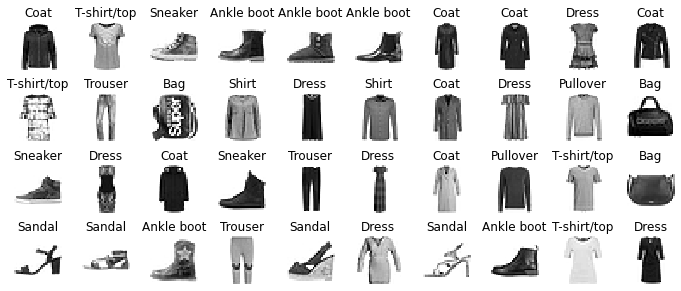

In [32]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Now let’s build the neural network: it is a classification MLP with two hidden layers. 

We user the **Sequential model**, which is the simplest kind of Keras model for ANN: just a single stack of layers connected sequentially. Next, we build the layers and add them to the model. 
The first is a **Flatten layer** whose role is to convert each input image into a 1D array. This layer does not have any parameters; it is just there to do some simple preprocessing. Since it is the first layer in the model, we have to specify the input_shape. Then we the two  **Dense hidden layer** with 300 and 100 neurons, using the ReLU activation function. Finally, we add a **Dense output layer** with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive).

The **summary()** method displays all the model’s layers, including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters.

In [33]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

print(model.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_67 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_68 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
None


Note that Dense layers often have a lot of parameters. For example, the first
hidden layer has 784×300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters. This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data.

All the parameters of a layer can be accessed using its **get_weights()** and
**set_weights()** methods.

In [34]:
hidden1 = model.layers[1]
print(hidden1.name)

weights, biases = hidden1.get_weights()

print(weights)
print(weights.shape)

print(biases)
print(biases.shape)

dense_66
[[-0.05910184 -0.06008741  0.01124956 ...  0.06276143  0.00147209
   0.02899364]
 [ 0.03019756 -0.00688709  0.06439912 ... -0.03455481  0.01398028
  -0.0545612 ]
 [-0.0648502   0.03086779 -0.03512588 ... -0.05779062 -0.01215937
   0.04775871]
 ...
 [ 0.03376858  0.00732899 -0.06930728 ...  0.0230137   0.04271291
  -0.07251959]
 [-0.06020889 -0.01779971  0.00921077 ... -0.06878211 -0.06707805
   0.00475204]
 [-0.0516833   0.01803482 -0.00489502 ...  0.04778166  0.07151346
   0.05546339]]
(784, 300)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Notice that the Dense layer initialized the connection weights randomly (which is needed to break symmetry), and the biases were initialized to zeros, which is fine.

After a model is created, we have to call the **compile()** method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation.

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

First, we use the **sparse_categorical_crossentropy loss** because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors), then we would need to use the **categorical_crossentropy loss** instead. If we were doing binary classification (with one or more binary labels), then we would we would use the **binary_crossentropy loss**.

Now the model is ready to be trained. For this we simply need to call the 
**fit()** method, passing it the input features (X_train), the target classes (y_train), the number of epochs to train and the validation set. 
Keras will measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set.

In [36]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7317 - accuracy: 0.7604 - val_loss: 0.5359 - val_accuracy: 0.8144
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4909 - accuracy: 0.8279 - val_loss: 0.4525 - val_accuracy: 0.8404
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4455 - accuracy: 0.8443 - val_loss: 0.4278 - val_accuracy: 0.8518
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4173 - accuracy: 0.8546 - val_loss: 0.4140 - val_accuracy: 0.8596
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3968 - accuracy: 0.8606 - val_loss: 0.3845 - val_accuracy: 0.8656
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3805 - accuracy: 0.8652 - val_loss: 0.3868 - val_accuracy: 0.8656
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3670 - accuracy: 0.8700 - val_loss: 0.3653 - val_accuracy:

That’s it! The neural network is trained. At each epoch during training, Keras displays the number of instances processed so far (along with a progress bar), the mean training time per sample, and the loss and accuracy (or any other extra metrics you asked for) on both the training se and the validation set. 

You can see that the training loss went down, which is a good sign, and the validation accuracy reached 89.26% after 30 epochs. That’s not too far from the training accuracy, so there does not seem to be much overfitting going on.

The fit() method returns a **History object** containing the training parameters (history.params), the list of epochs it went through (history.epoch), and most importantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch
on the training set and on the validation set. We can use this dictionary to plot the learning curves:

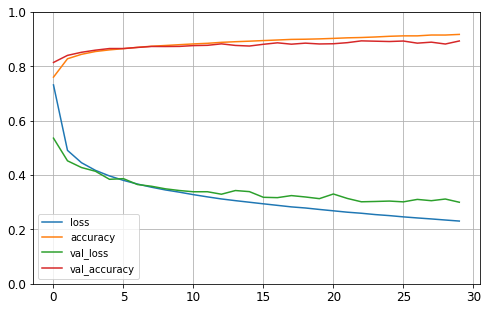

In [37]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. The validation curves are close to the training curves, which means that there is not too much overfitting.

Probably the model has not converged yet, as the validation loss is still going down, so we should probably continue training. It’s as simple as calling the fit() method again, since Keras just continues training where it left off.

If we are not satisfied with the performance of the model, we can go back and tune the hyperparameters. The first one to check is the **learning rate**. If that doesn’t help, **try another optimizer** (and always retune the learning rate after changing any hyperparameter). If the performance is still not great, then **try tuning model hyperparameters** (number of layers, number of neurons per layer, types of activation functions. We can also try tuning other hyperparameters, such as the **batch size**.

Once we are satisfied with the model validation accuracy, we have to evaluate it on the test set to estimate the **generalization error** before we deploy it to production. We can easily do this using the **evaluate()** method:

In [38]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 747us/step - loss: 0.3339 - accuracy: 0.8821


[0.3338923454284668, 0.882099986076355]

Remember to resist the temptation to tweak the hyperparameters on the test set, or else your estimate of the generalization error will be too optimistic.

Next, we can use the **predict()** method to make predictions on new instances:

In [39]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

## Build a Regressor

Let’s switch to the California housing problem and tackle it using a regression neural network. After loading the data, we split it into a training set, a validation set, and a test set, and we scale all the features:

In [40]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Using the Sequential API to build, train, evaluate, and use a regression MLP to make predictions is quite similar to what we did for classification. The main differences are the fact that the output layer has a single neuron
(since we only want to predict a single value), it uses no activation function, and the loss function is the mean squared error.

Epoch 1/20
363/363 [==============================] - 0s 731us/step - loss: 2.0124 - val_loss: 2.9634
Epoch 2/20
363/363 [==============================] - 0s 572us/step - loss: 0.7487 - val_loss: 1.0033
Epoch 3/20
363/363 [==============================] - 0s 560us/step - loss: 0.6677 - val_loss: 0.6426
Epoch 4/20
363/363 [==============================] - 0s 585us/step - loss: 0.6281 - val_loss: 0.5727
Epoch 5/20
363/363 [==============================] - 0s 591us/step - loss: 0.5957 - val_loss: 0.7044
Epoch 6/20
363/363 [==============================] - 0s 581us/step - loss: 0.5704 - val_loss: 0.5356
Epoch 7/20
363/363 [==============================] - 0s 572us/step - loss: 0.5454 - val_loss: 0.4983
Epoch 8/20
363/363 [==============================] - 0s 596us/step - loss: 0.5243 - val_loss: 0.4937
Epoch 9/20
363/363 [==============================] - 0s 590us/step - loss: 0.5067 - val_loss: 0.5336
Epoch 10/20
363/363 [==============================] - 0s 608us/step - loss: 0.492

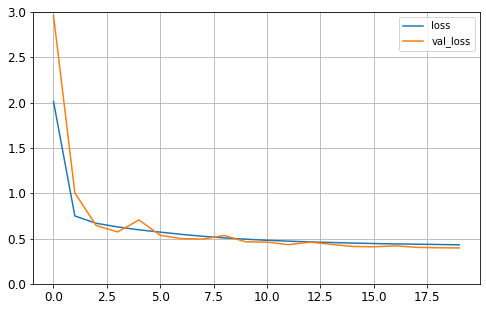

In [41]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

## Functional API

The Sequential API is quite easy to use. However, although sequential models are extremely common, it is sometimes useful to build neural networks with more **complex topologies**. For this purpose, Keras offers the **Functional API**.

One example of a nonsequential neural network is a (**Wide & Deep neural network**)[https://dl.acm.org/doi/pdf/10.1145/2988450.2988454]: it connects all or part of the inputs directly to the output layer. This architecture makes it possible to learn both deep patterns (using the deep path) and simple rules (through the short path). In contrast, a regular MLP forces all the data to flow through the full stack of layers; thus, simple patterns in the data may end up being distorted by this sequence of transformations.

<img src="widedeep_example.png" width="200"> <img src="widedeep.png" width="700">

First, we need to create an Input object. This is a specificatio of the kind of input the model will get, including its shape and
dtype.  Next, we create a Dense layer using the ReLU activation function. Notice that we call it like a function, passing it the input. This is why this is called the "Functional" API. We are just telling Keras how it should connect the layers together; no actual data is being processed yet. We then create a second hidden layer. Next, we create a Concatenate layer to concatenate the input and the output of the second hidden layer.  Then we create the output layer, with a single neuron and no activation function. Finally, we create a Keras Model, specifying which inputs an outputs to use. Once you have built the Keras model, everything is exactly like earlier: we compile the model, train it, evaluate it, and use it to make predictions.

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_71 (Dense)                (None, 30)           270         input_31[0][0]                   
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 30)           930         dense_71[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_31[0][0]                   
                                                                 dense_72[0][0]        

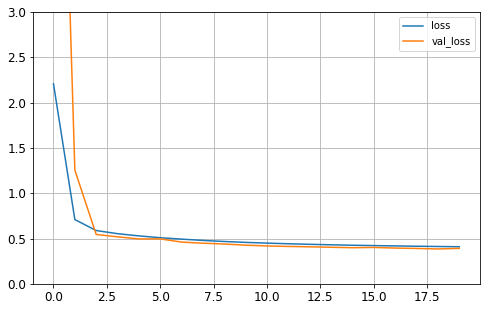

In [42]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

print(model.summary())

model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

But what if you want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path? One solution is to use **multiple inputs**. 

For example, suppose we want to send five features through the wide path
(features 0 to 4), and six features through the deep path (features 2 to 7)

<img src="multiple-inputs.png" width="300">

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_74 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_75 (Dense)                (None, 30)           930         dense_74[0][0]                   
_______________________________________________________________________________________

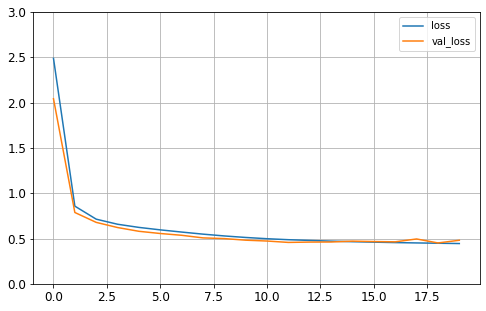

In [43]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

print(model.summary())

model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

There are many use cases in which you may want to have multiple outputs. The task may demand it. For instance, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object’s center, as well as its width
and height) and a classification task. 

Similarly, you may have multiple independent tasks based on the same data. You could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks. For example, you could perform multitask classification on pictures of faces, using one output to classify the person’s facial expression (smiling, surprised, etc.) and another output to identify whether they are wearing glasses or not. Another use case is adding some auxiliary outputs in a neural network architecture to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

<img src="muiltiple-outputs.png" width="400">

Each output needs its own loss function. Therefore, when we compile
the model, we should pass a list of losses. By default, Keras will compute all these losses and simply add them up to get the final loss used for training. We care much more about the main output than about the auxiliary output (as it is just used for regularization), so we want to give the main output’s loss a much greater weight. When we train the model, we need to provide labels for each output. In this example, the main output and the auxiliary output should try to predict the same thing, so they should use the same labels:

Epoch 1/20
363/363 [==============================] - 0s 926us/step - loss: 2.3719 - main_output_loss: 1.8953 - aux_output_loss: 6.6609 - val_loss: 1.5101 - val_main_output_loss: 1.0747 - val_aux_output_loss: 5.4281
Epoch 2/20
363/363 [==============================] - 0s 660us/step - loss: 1.1358 - main_output_loss: 0.7827 - aux_output_loss: 4.3131 - val_loss: 0.9895 - val_main_output_loss: 0.7324 - val_aux_output_loss: 3.3032
Epoch 3/20
363/363 [==============================] - 0s 704us/step - loss: 0.9090 - main_output_loss: 0.6911 - aux_output_loss: 2.8699 - val_loss: 0.8041 - val_main_output_loss: 0.6347 - val_aux_output_loss: 2.3286
Epoch 4/20
363/363 [==============================] - 0s 778us/step - loss: 0.7892 - main_output_loss: 0.6406 - aux_output_loss: 2.1271 - val_loss: 0.7284 - val_main_output_loss: 0.5953 - val_aux_output_loss: 1.9261
Epoch 5/20
363/363 [==============================] - 0s 710us/step - loss: 0.7179 - main_output_loss: 0.6036 - aux_output_loss: 1.7462 

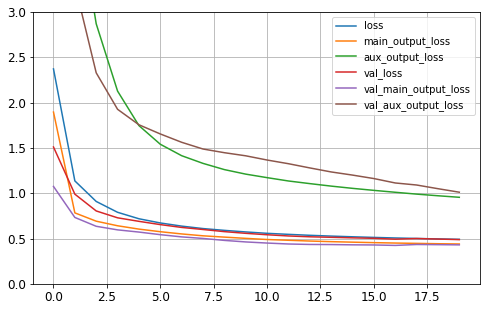

In [44]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit([X_train_A, X_train_B], 
                    [y_train, y_train], 
                    epochs=20,
                    validation_data=([X_valid_A, X_valid_B], 
                                     [y_valid, y_valid]))
                
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

When using the Sequential API or the Functional API, saving and loading a trained Keras model is really simple. It will use the **HDF5 format** to save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer (e.g., connection weights and biases). It also saves the optimizer (including its hyperparameters and any state it may have):

In [45]:
model.save("my_keras_model.h5")
model = keras.models.load_model("my_keras_model.h5")

## Subclassing API

Both the Sequential API and the Functional API are declarative: we start by declaring which layers we want to use and how they should be connected, and only then can we start feeding the model some data for training or inference. 

This has many advantages: the model can easily be saved, cloned, and shared, its structure can be displayed and analyzed, the framework can infer shapes and check types, so errors can be caught early.

However, the model is static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the **Subclassing API** can be used:

In [46]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

model.compile(loss="mse", loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit((X_train_A, X_train_B), 
                    (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), 
                                     (y_valid, y_valid)))

total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), 
                                                 (y_test, y_test))
print('Total loss:', total_loss)
print('Main loss:', main_loss)
print('Aux loss:', aux_loss)

Epoch 1/10
363/363 [==============================] - 0s 998us/step - loss: 2.6618 - output_1_loss: 2.2015 - output_2_loss: 6.8042 - val_loss: 1.7387 - val_output_1_loss: 0.9731 - val_output_2_loss: 8.6294
Epoch 2/10
363/363 [==============================] - 0s 736us/step - loss: 1.2503 - output_1_loss: 0.8318 - output_2_loss: 5.0166 - val_loss: 1.1393 - val_output_1_loss: 0.7500 - val_output_2_loss: 4.6431
Epoch 3/10
363/363 [==============================] - 0s 661us/step - loss: 0.9919 - output_1_loss: 0.7212 - output_2_loss: 3.4281 - val_loss: 0.9039 - val_output_1_loss: 0.6866 - val_output_2_loss: 2.8597
Epoch 4/10
363/363 [==============================] - 0s 688us/step - loss: 0.8521 - output_1_loss: 0.6644 - output_2_loss: 2.5410 - val_loss: 0.8083 - val_output_1_loss: 0.6616 - val_output_2_loss: 2.1277
Epoch 5/10
363/363 [==============================] - 0s 762us/step - loss: 0.7651 - output_1_loss: 0.6218 - output_2_loss: 2.0550 - val_loss: 0.7131 - val_output_1_loss: 0.590

The big difference is that we can do pretty much anything we want in the call() method: for loops, if statements, low-level TensorFlow operations, etc... This makes it a great API for researchers experimenting with new ideas.

However, the model’s architecture is hidden within the call() method, so Keras cannot easily inspect it, it cannot save or clone it and the summary() method can provide jusrt a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. 

So unless we really need extra flexibility, we should probably stick to the Sequential API or the Functional API.

The saving an loafing feature will work when using the Sequential API or the Functional API, but unfortunately not when using model subclassing. In that case, we can use **save_weights()** and **load_weights()** to at least save and restore the model parameters, but we will need to save and restore everything else ourself:

In [47]:
model.save_weights("my_keras_weights.ckpt")
model.load_weights("my_keras_weights.ckpt")

## Callbacks
What if training lasts several hours? This is quite common, especially when training on large datasets. In this case, we should not only save our model at the end of training, but also save **checkpoints** at regular intervals during training, to avoid losing everything in case of crashes. For this we can use the possibility to pass **callbacks functions** to the fit() method that Keras will call at the start and end of training, at the start
and end of each epoch, and even before and after processing each batch:

In [48]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
]) 

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", 
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

model = keras.models.load_model("my_keras_model.h5")

mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 794us/step - loss: 1.6852 - val_loss: 0.8738
Epoch 2/10
363/363 [==============================] - 0s 631us/step - loss: 0.7783 - val_loss: 0.7555
Epoch 3/10
363/363 [==============================] - 0s 620us/step - loss: 0.7103 - val_loss: 0.6574
Epoch 4/10
363/363 [==============================] - 0s 600us/step - loss: 0.6641 - val_loss: 0.6844
Epoch 5/10
363/363 [==============================] - 0s 636us/step - loss: 0.6260 - val_loss: 0.6239
Epoch 6/10
363/363 [==============================] - 0s 621us/step - loss: 0.5933 - val_loss: 0.5576
Epoch 7/10
363/363 [==============================] - 0s 668us/step - loss: 0.5663 - val_loss: 0.5206
Epoch 8/10
363/363 [==============================] - 0s 682us/step - loss: 0.5422 - val_loss: 0.5726
Epoch 9/10
363/363 [==============================] - 0s 654us/step - loss: 0.5217 - val_loss: 0.4828
Epoch 10/10
162/162 [==============================] - 0s 428us/step - loss: 0.493

In the example, the **ModelCheckpoint callback** saves checkpoints of our model at regular intervals during training, by default at the end of each epoch. Moreover, if we use a validation set during training, by setting
**save_best_only=True**  it will only save the model when its performance on the validation set is the best so far. This is a simple way to implement the **early stopping** concept. We can use also the **EarlyStopping callback**, that interrupt training when it measures no progress on the validation set for a number of epochs (defined by the **patience argument**). We can combine both callbacks to save checkpoints of your model (in case your computer crashes) and interrupt training early when there is no more progress (to avoid wasting time and resources). 

There are many other callbacks available in the keras.callbacks package and it is possible to write also custom callbacks, by implementing **on_train_begin()**, **on_train_end()**, **on_epoch_begin()**, **on_epoch_end()**, **on_batch_begin()**, and **on_batch_end()**. 

Callbacks can also be used during evaluation and predictions, should we ever need them (e.g., for debugging). For evaluation, we should implement **on_test_begin()**, **on_test_end()**, **on_test_batch_begin()**, or **on_test_batch_end()** during the evaluation; and **on_predict_begin()**, **on_predict_end()**, **on_predict_batch_begin()** and **on_predict_batch_end()** during prediction.

In [49]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Epoch 1/10
345/363 [===========================>..] - ETA: 0s - loss: 0.4907
val/train: 0.93
363/363 [==============================] - 0s 637us/step - loss: 0.4896 - val_loss: 0.4556
Epoch 2/10
341/363 [===========================>..] - ETA: 0s - loss: 0.4765
val/train: 0.93
363/363 [==============================] - 0s 601us/step - loss: 0.4773 - val_loss: 0.4434
Epoch 3/10
355/363 [============================>.] - ETA: 0s - loss: 0.4643
val/train: 0.94
363/363 [==============================] - 0s 579us/step - loss: 0.4662 - val_loss: 0.4359
Epoch 4/10
242/363 [===================>..........] - ETA: 0s - loss: 0.4648
val/train: 0.93
363/363 [==============================] - 0s 564us/step - loss: 0.4578 - val_loss: 0.4268
Epoch 5/10
245/363 [===================>..........] - ETA: 0s - loss: 0.4571
val/train: 0.96
363/363 [==============================] - 0s 557us/step - loss: 0.4500 - val_loss: 0.4339
Epoch 6/10
359/363 [============================>.] - ETA: 0s - loss: 0.4443
val

## TensorBoard
TensorBoard is an interactive visualization tool of TensorFlow that ywe can use to view the learning curves during training, compare learning curves between multiple runs, visualize the computation graph, analyze training statistics, view images generated by our models, visualize complex multidimensional data projected down to 3D and automatically clustered, etc...

To use it, we need to modify the program so that it outputs the data to special binary log files called **event files**. Each binary data record is called a **summary**. 

The TensorBoard server will monitor the log directory, and it will automatically pick up the changes and update the visualizations: this allows the visualization of live data such as the learning curves during training. 

In [50]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

#%load_ext tensorboard
#%tensorboard --logdir=./my_logs --port=6006

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 1.5887 - val_loss: 3.1339
Epoch 2/30
363/363 [==============================] - 0s 530us/step - loss: 0.7897 - val_loss: 0.7626
Epoch 3/30
363/363 [==============================] - 0s 534us/step - loss: 0.7165 - val_loss: 0.6881
Epoch 4/30
363/363 [==============================] - 0s 535us/step - loss: 0.6729 - val_loss: 0.6273
Epoch 5/30
363/363 [==============================] - 0s 614us/step - loss: 0.6360 - val_loss: 0.6141
Epoch 6/30
363/363 [==============================] - 0s 594us/step - loss: 0.6061 - val_loss: 0.5697
Epoch 7/30
363/363 [==============================] - 0s 580us/step - loss: 0.5790 - val_loss: 0.5436
Epoch 8/30
363/363 [==============================] - 0s 545us/step - loss: 0.5543 - val_loss: 0.5246
Epoch 9/30
363/363 [==============================] - 0s 549us/step - loss: 0.5330 - val_loss: 0.4993
Epoch 10/30
363/363 [==============================] - 0s 540us/step - loss: 0.5133 

In the example, we define the root log directory and we use a small function that will generate a subdirectory path based on the current date and time so that it’s different at every run. We can also to include extra information in the log directory name, such as hyperparameter values that you are testing, to make it easier to know what you are looking at in TensorBoard.  Then we make use of the Keras callback for Tensor Board.

We can use TensorBoard directly within Jupyter or we can start it from the command line running the following command at the root of the project (or from anywhere else, as long as you point to the appropriate log directory).

$ tensorboard --logdir=./my_logs --port=6006

Once the server is up, you can open a web browser and go to http://localhost:6006.

## Fine Tuning Hyperparameters

We can use GridSearchCV or RandomizedSearchCV to explore the hyperparameter space.  To do this, we need to wrap our Keras models in objects that mimic regular Scikit-Learn regressors. Using randomized or grid search is not too hard, and it works well for many fairly simple problems. When training is slow, however this approach will only explore a tiny portion of the hyperparameter space. we can partially alleviate this problem by assisting the search process manually: first run a quick random search using wide ranges of hyperparameter values, then run another search using smaller ranges of values centered on the best ones found during the first run, and so on. This approach will hopefully zoom in on a good set of hyperparameters. However, it’s very time consuming, and probably not the best use of your time.

Fortunately, there are many techniques to explore a search space much more efficiently than randomly. Their core idea is simple: when a region of the space turns out to be good, it should be explored more. Such techniques take care of the “zooming” process for you and lead to much better solutions in much less time. Here are some Python libraries we can use to optimize hyperparameters, like [Keras Tuner](https://github.com/keras-team/keras-tuner). Moreover, many companies offer services for hyperparameter optimization.

Hyperparameter tuning is still an active area of research, and **evolutionary
algorithms** are making a comeback. For example, check paper [Population Based Training of Neural Networks](https://arxiv.org/abs/1711.09846). Google used an evolutionary approach with the [AutoML](https://cloud.google.com/automl/) suite, which is already
available as a cloud service. Evolutionary algorithms have been used successfully to train individual neural networks, replacing the ubiquitous Gradient Descent. For getting more inf, you can check the [**Deep Neuroevolution technique**](https://eng.uber.com/deep-neuroevolution/).

But despite all this exciting progress and all these tools and services, it stillhelps to have an idea of what values are reasonable for each hyperparameter
so that you can build a quick prototype and restrict the search space. The
following sections provide guidelines for choosing the number of hidden
layers and neurons in an MLP and for selecting good values for some of the
main hyperparameters.

## Exercise

**1 - Train a deep MLP on the MNIST dataset (you can load it using keras.datasets.mnist.load_data(). See if you can get over 98% precision. Try searching for the optimal learning rate (by growing the learning rate exponentially, plotting the error, and finding the point where the error shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.**

Let's load the dataset:

In [91]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [92]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        keras.backend.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch and plot the loss as a function of the learning rate:

1719/1719 [==============================] - 4s 2ms/step - loss: 16.2163 - accuracy: 0.5745 - val_loss: 2.3911 - val_accuracy: 0.1126


Text(0, 0.5, 'Loss')

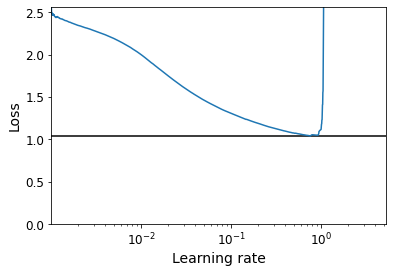

In [94]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently around 3e-1, so let's try using 2e-1 as our learning rate:

In [100]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [101]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

model = keras.models.load_model("my_mnist_model.h5")
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2380 - accuracy: 0.9270 - val_loss: 0.1029 - val_accuracy: 0.9676
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0952 - accuracy: 0.9710 - val_loss: 0.0855 - val_accuracy: 0.9766
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0640 - accuracy: 0.9800 - val_loss: 0.0765 - val_accuracy: 0.9776
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0472 - accuracy: 0.9842 - val_loss: 0.0770 - val_accuracy: 0.9776
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0342 - accuracy: 0.9889 - val_loss: 0.0727 - val_accuracy: 0.9816
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0267 - accuracy: 0.9915 - val_loss: 0.0760 - val_accuracy: 0.9810
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0851 - val_accuracy:

[0.07175638526678085, 0.09910000115633011]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [103]:
#%tensorboard --logdir=./my_mnist_logs --port=6006